<a href="https://colab.research.google.com/github/keyanUB/hateful_memes_measure/blob/main/MMF_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download MMF and Dependencies

First we will install the MMF package and required dependencies

In [1]:
%env OC_DISABLE_DOT_ACCESS_WARNING = 1


env: OC_DISABLE_DOT_ACCESS_WARNING=1


In [2]:
import os
home = "/content"
os.chdir(home)
os.getcwd()

'/content'

In [ ]:
# Install specified versions of `torch` and `torchvision`, before installing mmf (causes an issue)
!pip install torch==1.6.0 torchvision==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [4]:
# Clone the following repo where mmf does not install default image features, 
# since we will use our own features
!git clone --branch no_feats --config core.symlinks=true https://github.com/rizavelioglu/mmf.git

Cloning into 'mmf'...
remote: Enumerating objects: 16724, done.
remote: Total 16724 (delta 0), reused 0 (delta 0), pack-reused 16724
Receiving objects: 100% (16724/16724), 12.78 MiB | 1.49 MiB/s, done.
Resolving deltas: 100% (10762/10762), done.


In [5]:
import os
os.chdir(os.path.join(home, "mmf"))

In [ ]:
!pip install --editable .

## Data processing

### Extract the image features

In [ ]:
# Download Pre-requisites needed for running the e2e model
%cd /content/

%mkdir model_data
!wget -O /content/model_data/answers_vqa.txt https://dl.fbaipublicfiles.com/pythia/data/answers_vqa.txt
!wget -O /content/model_data/vocabulary_100k.txt https://dl.fbaipublicfiles.com/pythia/data/vocabulary_100k.txt
!wget -O /content/model_data/detectron_model.pth  https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.pth 
!wget -O /content/model_data/pythia.pth https://dl.fbaipublicfiles.com/pythia/pretrained_models/vqa2/pythia_train_val.pth
!wget -O /content/model_data/pythia.yaml https://dl.fbaipublicfiles.com/pythia/pretrained_models/vqa2/pythia_train_val.yml
!wget -O /content/model_data/detectron_model.yaml https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.yaml
!wget -O /content/model_data/detectron_weights.tar.gz https://dl.fbaipublicfiles.com/pythia/data/detectron_weights.tar.gz
!tar xf /content/model_data/detectron_weights.tar.gz

In [ ]:
# Install dependencies
!pip install yacs cython matplotlib
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-pgctyg7h
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-pgctyg7h


### Install maskrcnn-benchmark

In [ ]:
# Install maskrcnn-benchmark to extract detectron features
%cd /content
!git clone https://gitlab.com/meetshah1995/vqa-maskrcnn-benchmark.git
%cd /content/vqa-maskrcnn-benchmark
# Compile custom layers and build mask-rcnn backbone
!python setup.py build
!python setup.py develop
import sys
sys.path.append('/content/vqa-maskrcnn-benchmark')

/content
fatal: destination path 'vqa-maskrcnn-benchmark' already exists and is not an empty directory.
/content/vqa-maskrcnn-benchmark
running build
running build_py
running build_ext
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:335: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
running develop
running egg_info
writing maskrcnn_benchmark.egg-info/PKG-INFO
writing dependency_links to maskrcnn_benchmark.egg-info/dependency_links.txt
writing top-level names to maskrcnn_benchmark.egg-info/top_level.txt
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:335: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
adding license file 'LICENSE'
writing man

### Demo

In [ ]:
%cd /content/mmf/
import yaml
import cv2
import torch
import requests
import numpy as np
import gc
import torch.nn.functional as F
import pandas as pd


import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout
from io import BytesIO
from argparse import Namespace


from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.layers import nms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.utils.model_serialization import load_state_dict


from mmf.datasets.processors.processors import VocabProcessor, VQAAnswerProcessor
from mmf.models.pythia import Pythia
from mmf.common.registry import registry
from mmf.common.sample import Sample, SampleList
from mmf.utils.env import setup_imports
from mmf.utils.configuration import Configuration

setup_imports()

class MMFDemo:
  TARGET_IMAGE_SIZE = [448, 448]
  CHANNEL_MEAN = [0.485, 0.456, 0.406]
  CHANNEL_STD = [0.229, 0.224, 0.225]
  
  def __init__(self):
    self._init_processors()
    self.pythia_model = self._build_pythia_model()
    self.detection_model = self._build_detection_model()
    self.resnet_model = self._build_resnet_model()
    
  def _init_processors(self):
    args = Namespace()
    args.opts = [
        "config=projects/pythia/configs/vqa2/defaults.yaml",
        "datasets=vqa2",
        "model=pythia",
        "evaluation.predict=True"
    ]
    args.config_override = None

    configuration = Configuration(args=args)
    
    config = self.config = configuration.config
    vqa_config = config.dataset_config.vqa2
    text_processor_config = vqa_config.processors.text_processor
    answer_processor_config = vqa_config.processors.answer_processor
    
    text_processor_config.params.vocab.vocab_file = "/content/model_data/vocabulary_100k.txt"
    answer_processor_config.params.vocab_file = "/content/model_data/answers_vqa.txt"
    # Add preprocessor as that will needed when we are getting questions from user
    self.text_processor = VocabProcessor(text_processor_config.params)
    self.answer_processor = VQAAnswerProcessor(answer_processor_config.params)

    registry.register("vqa2_text_processor", self.text_processor)
    registry.register("vqa2_answer_processor", self.answer_processor)
    registry.register("vqa2_num_final_outputs", 
                      self.answer_processor.get_vocab_size())
    
  def _build_pythia_model(self):
    state_dict = torch.load('/content/model_data/pythia.pth')
    model_config = self.config.model_config.pythia
    model_config.model_data_dir = "/content/"
    model = Pythia(model_config)
    model.build()
    model.init_losses()
    
    if list(state_dict.keys())[0].startswith('module') and \
       not hasattr(model, 'module'):
      state_dict = self._multi_gpu_state_to_single(state_dict)
          
    model.load_state_dict(state_dict, strict=False)
    model.to("cuda")
    model.eval()
    
    return model
  
  def _build_resnet_model(self):
    self.data_transforms = transforms.Compose([
        transforms.Resize(self.TARGET_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(self.CHANNEL_MEAN, self.CHANNEL_STD),
    ])
    resnet152 = models.resnet152(pretrained=True)
    resnet152.eval()
    modules = list(resnet152.children())[:-2]
    self.resnet152_model = torch.nn.Sequential(*modules)
    self.resnet152_model.to("cuda")
  
  def _multi_gpu_state_to_single(self, state_dict):
    new_sd = {}
    for k, v in state_dict.items():
        if not k.startswith('module.'):
            raise TypeError("Not a multiple GPU state of dict")
        k1 = k[7:]
        new_sd[k1] = v
    return new_sd
  
  def predict(self, url, question):
    with torch.no_grad():
      detectron_features = self.get_detectron_features(url)
      resnet_features = self.get_resnet_features(url)

      sample = Sample()

      processed_text = self.text_processor({"text": question})
      sample.text = processed_text["text"]
      sample.text_len = len(processed_text["tokens"])

      sample.image_feature_0 = detectron_features
      sample.image_info_0 = Sample({
          "max_features": torch.tensor(100, dtype=torch.long)
      })

      sample.image_feature_1 = resnet_features

      sample_list = SampleList([sample])
      sample_list = sample_list.to("cuda")

      scores = self.pythia_model(sample_list)["scores"]
      scores = torch.nn.functional.softmax(scores, dim=1)
      actual, indices = scores.topk(5, dim=1)

      top_indices = indices[0]
      top_scores = actual[0]

      probs = []
      answers = []

      for idx, score in enumerate(top_scores):
        probs.append(score.item())
        answers.append(
            self.answer_processor.idx2word(top_indices[idx].item())
        )
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return probs, answers
    
  
  def _build_detection_model(self):

      cfg.merge_from_file('/content/model_data/detectron_model.yaml')
      cfg.freeze()

      model = build_detection_model(cfg)
      checkpoint = torch.load('/content/model_data/detectron_model.pth', 
                              map_location=torch.device("cpu"))

      load_state_dict(model, checkpoint.pop("model"))

      model.to("cuda")
      model.eval()
      return model
  
  def get_actual_image(self, image_path):
      if image_path.startswith('http'):
          path = requests.get(image_path, stream=True).raw
      else:
          path = image_path
      
      return path

  def _image_transform(self, image_path):
      path = self.get_actual_image(image_path)

      img = Image.open(path)
      im = np.array(img).astype(np.float32)
      im = im[:, :, ::-1]
      im -= np.array([102.9801, 115.9465, 122.7717])
      im_shape = im.shape
      im_size_min = np.min(im_shape[0:2])
      im_size_max = np.max(im_shape[0:2])
      im_scale = float(800) / float(im_size_min)
      # Prevent the biggest axis from being more than max_size
      if np.round(im_scale * im_size_max) > 1333:
           im_scale = float(1333) / float(im_size_max)
      im = cv2.resize(
           im,
           None,
           None,
           fx=im_scale,
           fy=im_scale,
           interpolation=cv2.INTER_LINEAR
       )
      img = torch.from_numpy(im).permute(2, 0, 1)
      return img, im_scale


  def _process_feature_extraction(self, output,
                                 im_scales,
                                 feat_name='fc6',
                                 conf_thresh=0.2):
      batch_size = len(output[0]["proposals"])
      n_boxes_per_image = [len(_) for _ in output[0]["proposals"]]
      score_list = output[0]["scores"].split(n_boxes_per_image)
      score_list = [torch.nn.functional.softmax(x, -1) for x in score_list]
      feats = output[0][feat_name].split(n_boxes_per_image)
      cur_device = score_list[0].device

      feat_list = []

      for i in range(batch_size):
          dets = output[0]["proposals"][i].bbox / im_scales[i]
          scores = score_list[i]

          max_conf = torch.zeros((scores.shape[0])).to(cur_device)

          for cls_ind in range(1, scores.shape[1]):
              cls_scores = scores[:, cls_ind]
              keep = nms(dets, cls_scores, 0.5)
              max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep],
                                           cls_scores[keep],
                                           max_conf[keep])

          keep_boxes = torch.argsort(max_conf, descending=True)[:100]
          feat_list.append(feats[i][keep_boxes])
      return feat_list

  def masked_unk_softmax(self, x, dim, mask_idx):
      x1 = F.softmax(x, dim=dim)
      x1[:, mask_idx] = 0
      x1_sum = torch.sum(x1, dim=1, keepdim=True)
      y = x1 / x1_sum
      return y
   
  def get_resnet_features(self, image_path):
      path = self.get_actual_image(image_path)
      img = Image.open(path).convert("RGB")
      img_transform = self.data_transforms(img)
      
      if img_transform.shape[0] == 1:
        img_transform = img_transform.expand(3, -1, -1)
      img_transform = img_transform.unsqueeze(0).to("cuda")
      
      features = self.resnet152_model(img_transform).permute(0, 2, 3, 1)
      features = features.view(196, 2048)
      return features
    
  def get_detectron_features(self, image_path):
      im, im_scale = self._image_transform(image_path)
      img_tensor, im_scales = [im], [im_scale]
      current_img_list = to_image_list(img_tensor, size_divisible=32)
      current_img_list = current_img_list.to('cuda')
      with torch.no_grad():
          output = self.detection_model(current_img_list)
      feat_list = self._process_feature_extraction(output, im_scales, 
                                                  'fc6', 0.2)
      return feat_list[0]
    

/content/mmf


In [ ]:
demo = MMFDemo()

In [ ]:
import cv2
import os

def load_images_from_folder(folder):
    index = 0
    images = []
    for filename in os.listdir(folder):
        img = os.path.join(folder,filename)
        
        if img is not None:
            images.append(img)
        index+=1
    print(index)
    return images

In [ ]:
images = load_images_from_folder("/content/drive/MyDrive/hatememe/")

4988


In [ ]:
im = cv2.imread(images[1])
im.shape

(675, 1200, 3)

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11333859971472002666, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 13893369856
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4405586591653526203
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [ ]:
demo.get_detectron_features(image_path=images[1])

/content/vqa-maskrcnn-benchmark/maskrcnn_benchmark/structures/boxlist_ops.py:45: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = ((ws >= min_size) & (hs >= min_size)).nonzero().squeeze(1)


tensor([[4.4082, 3.8096, 0.0000,  ..., 4.1556, 3.2757, 0.0000],
        [0.1629, 0.0000, 2.3643,  ..., 0.0000, 2.7843, 0.0000],
        [2.6331, 0.0000, 2.6687,  ..., 0.0000, 0.5167, 0.0000],
        ...,
        [0.9418, 0.0000, 1.3415,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 2.7743, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 7.7517, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [ ]:
df = pd.DataFrame(images, columns=['img_path'])
df['img_path'] =  df['img_path'].apply(lambda x: str(x).replace('"', ''))
print(df)

                                              img_path
0      /content/drive/MyDrive/hatememe/hatememe788.jpg
1      /content/drive/MyDrive/hatememe/hatememe628.jpg
2      /content/drive/MyDrive/hatememe/hatememe431.jpg
3      /content/drive/MyDrive/hatememe/hatememe877.jpg
4      /content/drive/MyDrive/hatememe/hatememe864.jpg
...                                                ...
4983  /content/drive/MyDrive/hatememe/hatememe4600.jpg
4984  /content/drive/MyDrive/hatememe/hatememe3417.jpg
4985  /content/drive/MyDrive/hatememe/hatememe3455.jpg
4986  /content/drive/MyDrive/hatememe/hatememe3432.jpg
4987  /content/drive/MyDrive/hatememe/hatememe3401.jpg

[4988 rows x 1 columns]


In [ ]:
def detect_feature(img_path):
  try:
    img_feature = demo.get_detectron_features(image_path=img_path)
    #print(img_feature)
    return img_feature
  except:
    return "none"

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()
df['img_feature'] = df['img_path'].progress_apply(detect_feature)

  0%|          | 0/4988 [00:00<?, ?it/s]

In [ ]:
df.iloc[1,-1]

tensor([[4.4082, 3.8096, 0.0000,  ..., 4.1556, 3.2757, 0.0000],
        [0.1629, 0.0000, 2.3643,  ..., 0.0000, 2.7843, 0.0000],
        [2.6331, 0.0000, 2.6687,  ..., 0.0000, 0.5167, 0.0000],
        ...,
        [0.9418, 0.0000, 1.3415,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 2.7743, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 7.7517, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [ ]:
torch.save(df, tensor)

'[\n    {\n        "img_path": "/content/drive/MyDrive/hatememe/hatememe788.jpg",\n        "img_feature": "tensor([[1.6364, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],\\n        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],\\n        [0.0000, 0.0000, 0.3523,  ..., 0.0000, 0.0000, 0.0000],\\n        ...,\\n        [1.4728, 3.9944, 0.0000,  ..., 0.0000, 0.0000, 0.0000],\\n        [2.8902, 1.3520, 0.0000,  ..., 0.0000, 0.0000, 0.0000],\\n        [1.2128, 2.9646, 1.2267,  ..., 0.0000, 0.0000, 0.0000]],\\n       device=\'cuda:0\')"\n    },\n    {\n        "img_path": "/content/drive/MyDrive/hatememe/hatememe628.jpg",\n        "img_feature": "tensor([[4.4082, 3.8096, 0.0000,  ..., 4.1556, 3.2757, 0.0000],\\n        [0.1629, 0.0000, 2.3643,  ..., 0.0000, 2.7843, 0.0000],\\n        [2.6331, 0.0000, 2.6687,  ..., 0.0000, 0.5167, 0.0000],\\n        ...,\\n        [0.9418, 0.0000, 1.3415,  ..., 0.0000, 0.0000, 0.0000],\\n        [0.0000, 2.7743, 0.0000,  ..., 0.0000, 0.0000, 0.0000],

In [ ]:
df_tk = pd.read_csv('/content/drive/MyDrive/hate_csv/with_token.csv')

In [ ]:
df_tk['img_feature'] = df['img_feature']

In [ ]:
df_tk.to_csv(('/content/drive/MyDrive/hate_csv/hate_input.csv'))

In [8]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/hate_csv/hate_input.csv')

In [18]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df

,img_path,image_text,token,img_feature
0,./annot_3000_hate/EfzVXLnX0AIp4ZB.jpg,"""©KIK ""The MAGA voters love me, the MAGA voter...","{'input_ids': tensor([[ 101, 1000, 1075, 3...","tensor([[1.6364, 0.0000, 0.0000, ..., 0.0000,..."
1,./annot_3000_hate/EyJTcl3WEAIGS0A.jpg,"""New Confirmed Cases 30k Z6K Show All 25k 20k ...","{'input_ids': tensor([[ 101, 1000, 2047, 4...","tensor([[4.4082, 3.8096, 0.0000, ..., 4.1556,..."
2,./annot_3000_hate/EepwWgJWoAA3pBS.jpg,"""THIS IS NOT NORMAL DON'T EVEN PRETEND THIS IS...","{'input_ids': tensor([[ 101, 1000, 2023, 2003,...","tensor([[1.6138, 1.1490, 0.0000, ..., 0.0000,..."
3,./annot_3000_hate/Epa2xTmVEAA70b9.jpg,"""fungyware your life, your rules, your fung Lw...","{'input_ids': tensor([[ 101, 1000, 4569, 6292,...","tensor([[2.1147, 0.0000, 0.3049, ..., 1.1031,..."
4,./annot_3000_hate/EQlrbqFVAAACJSY.jpg,"""INCUMBENT VOTING IN NEW HAMPSHIRE 2012 2004 1...","{'input_ids': tensor([[ 101, 1000, 7703, 6830,...","tensor([[0.0000, 0.8891, 1.9499, ..., 3.4074,..."
...,...,...,...,...
4995,./annot_2000_no_politics/EpVrM1uVoAMwWRa.jpg,"""Xi: heheh just gonna destroy the world & húnt...","{'input_ids': tensor([[ 101, 1000, 8418, 1...",NaN
4996,./annot_2000_no_politics/Ez6x142WEAI5tbs.jpg,"""The wrong man, in the wrong job at the wrong ...","{'input_ids': tensor([[ 101, 1000, 1996, 3308,...",NaN
4997,./annot_2000_no_politics/EVGGcGlWsAk0ZMJ.jpg,"""Flip-Flop: Biden Now Backs Trump Travel Ban A...","{'input_ids': tensor([[ 101, 1000, 11238, 1...",NaN
4998,./annot_2000_no_politics/EgOuPBLWsAYxDiA.jpg,"""12 months 9 months 3 months Covid 19 China 6 ...","{'input_ids': tensor([[ 101, 1000, 2260, 2...",NaN


## Import the facebook hateful memes dataset to train the model

In [22]:
#@title Please specify the download link and the `.zip` password which both can be taken from [DrivenData](https://www.drivendata.org/competitions/70/hateful-memes-phase-2/data/) { run: "auto" }

# YOUR_LINK_TO_DOWNLOAD_DATA = 'https://drive.google.com/uc?export=download&id=1qkwgAn5Y20scpWNAs3dvvR3jXEhn7r_x' #@param {type:"string"}
PASSWORD_OF_ZIP = 'EWryfbZyNviilcDF' #@param {type:"string"}

In [20]:
# !wget -O facebook_hatememe.zip --no-check-certificate --no-proxy "$YOUR_LINK_TO_DOWNLOAD_DATA"
from zipfile import ZipFile
facebook_hatememe = "/content/drive/MyDrive/hateful_memes_dataset.zip"

In [23]:
!mmf_convert_hm --zip_file="/content/drive/MyDrive/hateful_memes_dataset.zip" --password=$PASSWORD_OF_ZIP --bypass_checksum 1

Data folder is /root/.cache/torch/mmf/data
Zip path is /content/drive/MyDrive/hateful_memes_dataset.zip
Copying /content/drive/MyDrive/hateful_memes_dataset.zip
Unzipping /content/drive/MyDrive/hateful_memes_dataset.zip
Extracting the zip can take time. Sit back and relax.
Moving train.jsonl
Moving dev_seen.jsonl
Moving test_seen.jsonl
Moving dev_unseen.jsonl
Moving test_unseen.jsonl
Moving img


In [24]:
# Check how many images we have in total
!ls /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/img/ | wc -l

12140


In [25]:
# Free up the disk by removing .zip, .tar files
!rm -rf /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/content/drive/MyDrive/hateful_memes_dataset.zip

## Visualize some data

In [ ]:
!pip install imgaug==0.2.5
!pip install matplotlib==3.1.3


[ Downloading: https://dl.fbaipublicfiles.com/mmf/data/datasets/hateful_memes/defaults/extras.tar.gz to /root/.cache/torch/mmf/data/datasets/hateful_memes/defaults/extras.tar.gz ]


[ Starting checksum for extras.tar.gz]
[ Checksum successful for extras.tar.gz]
Unpacking extras.tar.gz


/root/.cache/torch/mmf/glove.6B.zip: 862MB [02:43, 5.27MB/s]                           
100%|█████████▉| 399999/400000 [00:56<00:00, 7130.18it/s]


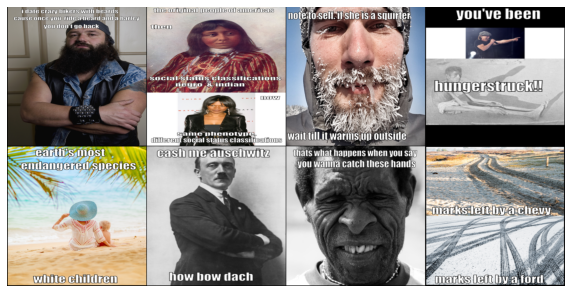

In [27]:
from mmf.common.registry import registry
from mmf.utils.build import build_dataset
from mmf.utils.env import setup_imports

setup_imports()
dataset = build_dataset("hateful_memes")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 10)
dataset.visualize(num_samples=8, size=(512, 512), nrow=4)

## Loading pretrained model 

In [28]:
model_cls = registry.get_model_class("visual_bert")
model = model_cls.from_pretrained("visual_bert.finetuned.hateful_memes.direct")


[ Downloading: https://dl.fbaipublicfiles.com/mmf/data/models/visual_bert/visual_bert.finetuned.hateful_memes_direct.tar.gz to /root/.cache/torch/mmf/data/models/visual_bert.finetuned.hateful_memes.direct/visual_bert.finetuned.hateful_memes_direct.tar.gz ]


[ Starting checksum for visual_bert.finetuned.hateful_memes_direct.tar.gz]
[ Checksum successful for visual_bert.finetuned.hateful_memes_direct.tar.gz]
Unpacking visual_bert.finetuned.hateful_memes_direct.tar.gz


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of VisualBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.embeddings.token_type_embeddings_visual.weight', 'bert.embeddings.position_embeddings_visual.weight', 'bert.embeddings.projection.weight', 'bert.embeddings.projection.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Missing keys ['model.bert.embeddings.position_ids'] in the checkpoint.
If this is not your checkpoint, please open up an issue on MMF GitHub. 
Unexpected keys if any: []


### Test the pre-trained model MMBT

In [32]:
# find input for the visual bert
tensor1 = df['img_feature'].iloc[0]
#print(tensor1)
tensor2 = df['token'].iloc[0]
print(tensor2)

{'input_ids': tensor([[  101,  1000,  1075,  3211,  2243,  1000,  1996, 23848,  2050,  7206,
          2293,  2033,  1010,  1996, 23848,  2050,  7206,  2024,  2561, 23160,
          1010,  1996, 23848,  2050,  7206,  2293,  2033,  1010,  1996, 23848,
          2050,  7206,  2024,  2561, 23160,  1010,  1012,  1012,  1012,  1000,
           102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


merge two tensors to a single input, need to remove the newline symbols


In [40]:
#import tensorflow as tf
input_VB = torch.cat([tensor2, tensor1],0)
print(input_VB)

TypeError: ignored

In [34]:
#@title  { vertical-output: true }
#@title  { vertical-output: true }
# image_url = "/content/drive/MyDrive/hatememe/hatememe1.jpg" #@param {type:"string"}
# text = "The MAGA voters love me, the MAGA voter." #@param {type: "string"}
# output = model.classify(image_url,text)

# test with the pretrained visual bert
output = model(tensor1,tensor2)
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")

/content/mmf/mmf/common/sample.py:405: UserWarning: You are not returning SampleList/Sample from your dataset. MMF expects you to move your tensors to cuda yourself.
  "You are not returning SampleList/Sample from your dataset. "


TypeError: ignored

In [ ]:
plt.imshow(Image.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")

In [ ]:
!mmf_predict config= "projects/hateful_memes/configs/visual_bert/direct.yaml" model="visual_bert" dataset=hateful_memes \
run_type=test checkpoint.resume_zoo="visual_bert.finetuned.hateful_memes.direct" checkpoint.resume_pretrained=False


In [ ]:
model_vb_coco = model_cls.from_pretrained("visual_bert.finetuned.hateful_memes.from_coco")